In [ ]:
# tham khảo https://www.youtube.com/watch?v=hOCDJyZ6quA&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=47

In [1]:
!pip3 install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.0 MB/s 
     |████████████████████████████████| 462 kB 47.4 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [6]:
import os

path = "/content/drive/MyDrive/Colab Notebooks/Project/"

In [7]:
import json

with open(os.path.join(path, "Src/news_train.json"), "r", encoding="utf-8") as file:
  news_data = json.load(file)

In [8]:
# dữ liệu dict 
# key là chủ đề (kinh tế, đời sống, ...)
# value là mảng các bài báo theo chủ đề đó
topics = list(news_data.keys())
topics

['Doi song',
 'Chinh tri Xa hoi',
 'Khoa hoc',
 'Suc khoe',
 'Phap luat',
 'Vi tinh',
 'Kinh doanh',
 'The thao',
 'The gioi',
 'Van hoa']

In [15]:
import pandas as pd

news_df = pd.DataFrame();

for t in topics:
  df = pd.DataFrame(news_data[t], columns=["News"])
  df["Topics"] = t
  
  news_df = news_df.append(df)

news_df

,News,Topics
0,Để trẻ em phát triển không bị lệch lạc về giới...,Doi song
1,Sò huyết Ô Loan \nĐầm Ô Loan thuộc huyện Tuy A...,Doi song
2,Anh Phan đã làm uổng công độc giả\nEm nghĩ rằn...,Doi song
3,Tôi có nên tiếp tục tình yêu với anh?\nAnh muố...,Doi song
4,"Bình giữ nhiệt nóng, lạnh\nVới hai tính năng v...",Doi song
...,...,...
3075,Phương Thanh - nữ hoàng của ánh đèn màu\nTôi l...,Van hoa
3076,Anti-fan - nỗi kinh hoàng của 'sao'\nTiếng vỗ ...,Van hoa
3077,Hóa trang với những tình huống bi hài\nTrong p...,Van hoa
3078,So Ji Sub - nam diễn viên nam xuất sắc\nTại Hà...,Van hoa


In [17]:
df = pd.DataFrame(news_df["Topics"].apply(lambda x: topics.index(x)))
df["News"] = news_df["News"]
df.sample(10)

,Topics,News
1769,8,Những bức ảnh đoạt giải Pulitzer \nCarolyn Col...
2068,4,"Con dưới 12 tháng tuổi, cha mẹ không được ly ..."
1912,8,Mạnh thường quân hào phóng nhất \nÔng khẳng đ...
3519,4,Điều tra vụ tham ô ở Xí nghiệp Xăng dầu hàng k...
1697,4,Nhạc trữ tình hình minh họa... sex Minh họa c...
2784,7,U21 Ngân Hàng Đông Á lên ngôi quán quân\nHôm q...
3591,4,"Anh là kiểm lâm, em chở gỗ lậu\nĐội Kiểm lâm c..."
1896,4,Thủ phạm bắn trọng thương dân phòng ra đầu thú...
213,1,Công khai bồi hoàn đồng hồ nước phi mã (NLĐ)-...
895,9,Cát-xê cao cũng là biểu hiện đẳng cấp của ca s...


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["News"], df["Topics"], stratify=df["Topics"])

In [20]:
X_train.head(5)

2774    Koizumi đối mặt với sự phản đối ngày một lớn\n...
652     Italy bất ngờ trượt ngã\nItaly lại có một đêm ...
994      Lạm dụng "tắm trắng", "lột da" có thể gây bện...
2376     \nTay vợt số một Việt Nam Nguyễn Quang Minh g...
5171    Xuất hiện chất khí lạ dưới lòng đất ở Trà Vinh...
Name: News, dtype: object

In [21]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [22]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [23]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)["pooled_output"]


get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tommorrow?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435166 , -0.5132724 , -0.88845706, ..., -0.7474883 ,
        -0.7531471 ,  0.91964483],
       [-0.8408091 , -0.4274827 , -0.8279484 , ..., -0.57521796,
        -0.65080476,  0.8776021 ]], dtype=float32)>

In [24]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]], [e[2]])

array([[0.99540985]], dtype=float32)

In [26]:
# tạo tensorflow model
# Bert layers
text_input= tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural network layer
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs["pooled_output"])
l = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(l)

# construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [28]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=METRICS)

In [29]:
model.fit(X_train, y_train)

Epoch 1/10
792/792 [==============================] - 585s 723ms/step - loss: -559.7245 - accuracy: 0.1546 - precision: 0.9065 - recall: 0.9993
Epoch 2/10
792/792 [==============================] - 569s 719ms/step - loss: -1678.5009 - accuracy: 0.1546 - precision: 0.9065 - recall: 0.9993
Epoch 3/10
792/792 [==============================] - 573s 723ms/step - loss: -2796.0464 - accuracy: 0.1546 - precision: 0.9065 - recall: 0.9993
Epoch 4/10
792/792 [==============================] - 572s 722ms/step - loss: -3913.7595 - accuracy: 0.1546 - precision: 0.9065 - recall: 0.9993
Epoch 5/10
792/792 [==============================] - 578s 730ms/step - loss: -5030.9004 - accuracy: 0.1546 - precision: 0.9065 - recall: 0.9993
Epoch 6/10
792/792 [==============================] - 573s 723ms/step - loss: -6147.5117 - accuracy: 0.1546 - precision: 0.9065 - recall: 0.9993
Epoch 7/10
792/792 [==============================] - 567s 715ms/step - loss: -7265.7104 - accuracy: 0.1546 - precision: 0.9065 - r

In [30]:
model.evaluate(X_test, y_test)

264/264 [==============================] - 194s 731ms/step - loss: -11169.2324 - accuracy: 0.1547 - precision: 0.9066 - recall: 0.9993


[-11169.232421875, 0.15473933517932892, 0.906557559967041, 0.9993463754653931]

In [45]:
y_predicted = model.predict(X_test)

In [47]:
predicted = y_predicted.flatten()

In [48]:
predicted

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, predicted)
cm

array([[   2,  788,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1, 1304,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  455,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  846,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  967,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  620,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  638,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3, 1322,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  724,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,  769,    0,    0,    0,    0,    0,    0,    0,    0]])

Text(33.0, 0.5, 'Truth')

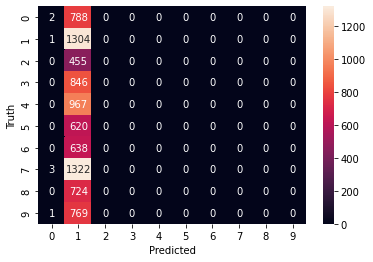

In [50]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [51]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.29      0.00      0.01       790
           1       0.15      1.00      0.27      1305
           2       0.00      0.00      0.00       455
           3       0.00      0.00      0.00       846
           4       0.00      0.00      0.00       967
           5       0.00      0.00      0.00       620
           6       0.00      0.00      0.00       638
           7       0.00      0.00      0.00      1325
           8       0.00      0.00      0.00       724
           9       0.00      0.00      0.00       770

    accuracy                           0.15      8440
   macro avg       0.04      0.10      0.03      8440
weighted avg       0.05      0.15      0.04      8440



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your .",
    "Máy vi tính nè"
]
model.predict(reviews)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [38]:
# model.save(os.path.join(path,"Bert/model_raw.model"));

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Project/Bert/model_raw.model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Project/Bert/model_raw.model/assets


In [43]:
# import pickle

# with open(os.path.join(path, "Bert/model_raw.pkl"), 'wb') as wb:
#     pickle.dump(model, wb)

INFO:tensorflow:Assets written to: ram://da958873-3d68-48ed-b0f7-1fa6b5c576a2/assets


INFO:tensorflow:Assets written to: ram://da958873-3d68-48ed-b0f7-1fa6b5c576a2/assets
